In [1]:
import pandas as pd
import getpass

import re
import matplotlib.pyplot as plt

import helpers

In [2]:
import sys

In [3]:
try:
    import pymysql
    conn = pymysql.connect(host="35.233.174.193",port=3306,
                           user="jovyan",passwd=getpass.getpass("Enter password for MIMIC2 database"),
                           db='mimic2')
    CACHED = False
except Exception as e:
    print("Importing pymysql failed. Using cached data instead")
    CACHED = True

Enter password for MIMIC2 database········
Importing pymysql failed. Using cached data instead


# Clinical Notes
One of the most information-rich sources of clinical data are free-text clinical notes. These are written narratives which discuss many topics of a patient's care, such as diagnoses, history, treatment, complications, etc... Free-text notes offer very detailed accounts of a patient's clinical course, making them very useful for many purposes. However, free text is not inherently meaningful. Unlike ICD-9 or LOINC codes, clinical language does not offer standardized representations of clinical concepts, and unlike vitals and labs, the information found in text cannot be easily quantified and represented in a computable way.

The field of **natural language processing** offers methods for dealing with text and extracting **structured information** from an **unstructured data source**. Later in the semester we'll have a module specifically devoted to NLP. Today we'll look at a couple of text processing methods which give us some insight into the information contained in text.

## Note types
There are many different types of notes in the clinical domain. Each note contains different information, often specific to clinical specialties like cardiology or surgery. One such specialty is radiology. MIMIC-II contains a large number of **radiology reports** which contain a radiologist's interpretation of an image. For example, if a physician suspects a patient has pneumonia, they might order a CT scan. The radiologist will view the image from the scan and determine whether or not has a patient has pneumonia.

## Querying notes
Clinical notes are contained in the table `noteevents`. We'll specifically query radiology notes. Additionally, since there are a large number of notes we'll limit our queries to only look at 1000 notes, although later we'll use a language model which was trained using all of the radiology notes in the database.

### TODO
Finish the query below to query the `noteevents` table and limit the results to notes where the category is "RADIOLOGY_REPORT".

In [4]:
query = """
select text from noteevents
where category = 'RADIOLOGY_REPORT'
limit 1000;
"""

In [9]:
# If we were able to import pymysql, we'll query MIMIC-II
if not CACHED:
    print("Querying MIMIC")
    df = pd.read_sql(query, conn)
# Otherwise, we'll use a smaller sample of documents in the repo
else:
    print("Reading saved files")
    df = helpers.read_pneumonia_documents('./pneumonia_data/training_v2/')

Reading saved files


In [10]:
len(df)

70

In [11]:
df.head()

,text
0,\n\n\n DATE: [**2717-5-23**] 12:06 PM\n ...
1,\n\n\n DATE: [**3368-3-20**] 11:46 AM\n ...
2,\n\n\n DATE: [**3106-8-10**] 11:46 AM\n ...
3,\n\n\n DATE: [**3469-9-13**] 6:54 PM\n ...
4,\n\n\n DATE: [**3346-10-31**] 4:35 PM\n ...


Let's take a quick look at what one of these notes looks like:

In [12]:
print(df['text'].iloc[0])




     DATE: [**2717-5-23**] 12:06 PM
     CHEST (PORTABLE AP); -76 BY SAME PHYSICIAN                      [**Name Initial (PRE) 58**] # [**Clip Number (Radiology) 4359**]
     Reason: s/p brochoscopy                                             
     Admitting Diagnosis: S/P FALL
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
        83 year old F w/ MS s/p fall. now intubated w/ desats.    leukocytosis.       
                                               
     REASON FOR THIS EXAMINATION:
      s/p brochoscopy                                                                 
     ______________________________________________________________________________
                                     FINAL REPORT
     INDICATION:  MS status post fall, now intubated with desaturations and
     leukocytosis, status post bronchoscopy.
     
     COMPARISON:  [**2717-5-23**] at 8:51 a.m.
     
     TECHNIQUE:  Single AP po

# Keyword search
One of the most basic things we can do with free text is to do a **keyword search**. Similar to a Google search, we want to find a set of documents which contain a specific phrase. In SQL, we can do this by using the `like` statement, which allows you to use wildcards. For example, the SQL clause `where text like %adve%` would return documents containing the words "adventure", "adventures", "advertisement", "advertise", etc...

### TODO
Limit the query below to only return documents where the text contains the word "pneumonia".

In [13]:
query = """
select subject_id, text from noteevents
where category = 'RADIOLOGY_REPORT'
    and text like '%pneumonia%'
limit 100
"""

In [14]:
if not CACHED:
    df = pd.read_sql(query, conn)
else: # Use a Regex filter in pandas
    df = df[df['text'].str.contains('pneumonia')]

Read through a few examples of the document. Where is pneumonia discussed? Do the patients actually have pneumonia? If not, why is it being mentioned?

In [15]:
print(df.iloc[0]['text'])




     DATE: [**3368-3-20**] 11:46 AM
     CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 2871**]
     Reason: fever, hypoxia, tachypnea- s/p AKA one week ago
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      [**Age over 90 **] year old woman with 
     REASON FOR THIS EXAMINATION:
      fever, hypoxia, tachypnea- s/p AKA one week ago
     ______________________________________________________________________________
                                     FINAL REPORT
     INDICATION:  Fever, hypoxia, tachypnea.
     
     COMPARISON:  [**3368-3-9**].
     
     SINGLE VIEW CHEST, AP:  There has been interval opacification within the left
     lower lobe consistent with consolidation.  The pulmonary vasculature is within
     normal limits.  The cardiac, mediastinal and hilar contours are unchanged with
     unfolding of the aorta and wall calcifications.  There 

## Text processing
Before doing any sort of computation with these texts, there are a number of steps to take to make the data easier to work with. Clinical text is **very** messy: it is very inconsistent, confusing, and often ugly. **Preprocessing** is where we clean up the text a little bit. Some possible steps for preprocessing include:
- Converting the text to lower case
- Replacing **"stop words"**: words or phrases which occur so often that they don't contain any useful information ("and", "or", "the", etc...)
- Merging phrases of 2 or more words
- Splitting texts into **"tokens"** (ie., individual words)

In [16]:
import text_processing

In [17]:
# Run this command to download some data needed for text processing:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# Original texts
texts = list(df['text'])

In [19]:
# Preprocessed texts
preprocessed_texts = [text_processing.preprocess(text) for text in texts]

In [20]:
# Tokenized texts
tokenized_texts = [text_processing.tokenize(text, rm_stopwords=True) for text in preprocessed_texts]

In [21]:
print(texts[0])




     DATE: [**3368-3-20**] 11:46 AM
     CHEST (PORTABLE AP)                                             Clip # [**Clip Number (Radiology) 2871**]
     Reason: fever, hypoxia, tachypnea- s/p AKA one week ago
     ______________________________________________________________________________
     UNDERLYING MEDICAL CONDITION:
      [**Age over 90 **] year old woman with 
     REASON FOR THIS EXAMINATION:
      fever, hypoxia, tachypnea- s/p AKA one week ago
     ______________________________________________________________________________
                                     FINAL REPORT
     INDICATION:  Fever, hypoxia, tachypnea.
     
     COMPARISON:  [**3368-3-9**].
     
     SINGLE VIEW CHEST, AP:  There has been interval opacification within the left
     lower lobe consistent with consolidation.  The pulmonary vasculature is within
     normal limits.  The cardiac, mediastinal and hilar contours are unchanged with
     unfolding of the aorta and wall calcifications.  There 

In [22]:
print(preprocessed_texts[0])




     date   am
     chest portable ap                                              
     reason fever hypoxia tachypnea- s/p aka one week ago
     
     underlying_medical_condition
       year old woman with 
     reason_for_this_examination
      fever hypoxia tachypnea- s/p aka one week ago
     
                                     final_report
     indication  fever hypoxia tachypnea
     
     comparison  
     
     single view chest ap  there has been interval opacification within the left
     lower lobe consistent with consolidation  the pulmonary vasculature is within
     normal limits  the cardiac mediastinal and hilar contours are unchanged with
     unfolding of the aorta and wall calcifications  there may be a left-sided
     pleural effusion also
     
     impression  left lower lobe pneumonia




In [23]:
print(tokenized_texts[0])

['date', 'chest', 'portable', 'ap', 'reason', 'fever', 'hypoxia', 'tachypnea-', 's/p', 'aka', 'one', 'week', 'ago', 'underlying_medical_condition', 'year', 'old', 'woman', 'reason_for_this_examination', 'fever', 'hypoxia', 'tachypnea-', 's/p', 'aka', 'one', 'week', 'ago', 'final_report', 'indication', 'fever', 'hypoxia', 'tachypnea', 'comparison', 'single', 'view', 'chest', 'ap', 'interval', 'opacification', 'within', 'left', 'lower', 'lobe', 'consistent', 'consolidation', 'pulmonary', 'vasculature', 'within', 'normal', 'limits', 'cardiac', 'mediastinal', 'hilar', 'contours', 'unchanged', 'unfolding', 'aorta', 'wall', 'calcifications', 'may', 'left-sided', 'pleural', 'effusion', 'also', 'impression', 'left', 'lower', 'lobe', 'pneumonia']


# Simple word counts
Now that we've preprocessed our text, we can do some very basic operations on it. Let's count how many times each word occurs and see what the most frequent words are. This will be useful for getting a high-level sense of what information is in our corpus.

In [24]:
from collections import defaultdict
counter = defaultdict(int)

In [25]:
for tokens in tokenized_texts:
    for token in tokens:
        counter[token] += 1

In [26]:
srtd_word_counts = sorted(counter.items(), key=lambda x:x[1], reverse=True)
srtd_word_counts[:25]

[('chest', 69),
 ('pneumonia', 58),
 ('right', 54),
 ('ap', 48),
 ('left', 44),
 ('portable', 39),
 ('year', 34),
 ('old', 34),
 ('lobe', 31),
 ('date', 30),
 ('reason', 30),
 ('underlying_medical_condition', 30),
 ('reason_for_this_examination', 30),
 ('final_report', 30),
 ('impression', 29),
 ('pleural', 26),
 ('tube', 26),
 ('lower', 25),
 ('normal', 22),
 ('bilateral', 22),
 ('pulmonary', 21),
 ('effusion', 21),
 ('woman', 19),
 ('history', 19),
 ('heart', 19)]

One nice way to visualize this is with a wordcloud:

In [27]:
from wordcloud import WordCloud

In [28]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(counter)

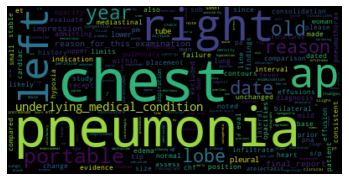

In [29]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word2Vec
Now, let's get into something a little more sophisticated. In the steps above, all we did was iterate through the documents and count how many times each word occurred. This gives us a high-level sense of what words are in this vocabulary, but it doesn't tell us anything about the **meaning** or **semantics** of these words.

In this next exercise we'll look at how we can use **machine learning** to generate some **semantic meaning** from the text. A method called **word embeddings** transforms words, which by default have no computational or semantic meaning, into vectors which contain some representation of what the words meaning. We won't go into the details here, but a quick summary is that we look at the **context** of word - the words nearby a target word - to estimate what it means. Words which occur in similar contexts probably mean similar things. 

For example, consider these 3 sentences:
- "I have a **dog** for a pet"
- "I have a **cat** for a pet"
- "I have a **fish** for a pet"

Since the context around "dog", "cat", and "fish" is very similar, they are probably similar semantically. We translate words into vectors, and words which have similar meanings have vectors. These vectors are called **word embeddings** and we can use them to measure the similarity between different words. If you're interested in learning more, here's a tutorial to get you started with word embeddings: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

One algorithm for generating word embeddings is called `word2vec`. I pretrained a word2vec model on all of the MIMIC-II radiology reports and saved it as a pickle file. Let's read this model in and do some experiments:

In [30]:
import pickle

In [31]:
# Load in the model corresponding to your Python version
saved_model_filepath = "./trained_word2vec_py{}.pkl".format(sys.version_info[0])
print(saved_model_filepath)

./trained_word2vec_py3.pkl


In [33]:
# Unzip the trained model
import zipfile
with zipfile.ZipFile(saved_model_filepath+'.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [34]:
with open(saved_model_filepath, 'rb') as f:
    model = pickle.load(f)

In [35]:
model

First, let's pick a target word which will occur in our vocabulary: **"abdomen"**. Let's first see what the embedding for "abdomen" looks like:

In [36]:
model.wv['abdomen']

array([-1.4888372e+00, -4.6089082e+00,  2.7482133e+00,  4.5480604e+00,
        6.5165091e+00,  6.8177408e-01, -7.3125161e-02, -1.7158018e-01,
        2.2183628e-01, -2.4804507e-01, -3.1339049e+00,  2.8161979e+00,
       -4.3838806e+00,  1.3561876e+00, -1.3171407e+00,  1.3502079e+00,
        2.4920027e+00, -6.5546697e-01,  1.0658654e+00,  3.4801486e-01,
       -1.3035367e+00,  1.2809013e+00, -4.0870538e-01, -3.6482475e+00,
       -3.8542290e+00,  9.8649848e-01,  3.5364735e+00,  3.6175384e-03,
        8.9614350e-01,  2.3398960e+00,  2.2755420e+00, -1.5685050e+00,
        2.4615960e+00,  2.7287574e+00, -2.8135452e+00, -6.1254710e-01,
       -2.6881001e+00, -1.6165260e+00,  1.9363427e+00, -1.7158920e+00,
       -2.3775711e+00, -3.9236513e-01,  5.9187371e-01, -2.2356038e+00,
       -8.0398381e-02, -4.1762033e-01,  2.3566065e+00, -2.8308094e+00,
        9.3105799e-01, -3.5327404e+00, -2.3993025e+00, -2.6222601e+00,
        1.2547103e-01,  3.9256761e+00, -2.0666819e+00,  4.2566839e-01,
      

Now, let's take two other words: "thorax" and "radiograph". Which do you think is more similar to abdomen?

In [37]:
print("Similarity between 'abdomen' and 'thorax':", model.wv.similarity('abdomen', 'thorax'))

Similarity between 'abdomen' and 'thorax': 0.5361971


In [38]:
print("Similarity between 'abdomen' and 'radiograph':", model.wv.similarity('abdomen', 'radiograph'))

Similarity between 'abdomen' and 'radiograph': 0.135372


Let's find what terms our model thinks are most similar to "abdomen":

In [39]:
model.most_similar(['abdomen'], topn=10)

/Users/alec/anaconda/envs/uvu/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('thorax', 0.5361971855163574),
 ('cervical_spine', 0.4499072730541229),
 ('thoracic_spine', 0.44829022884368896),
 ('poles_kidneys', 0.44651567935943604),
 ('bladder', 0.4408397376537323),
 ('mri_chest/mediastinum', 0.4390665292739868),
 ('abdominal', 0.4375646710395813),
 ('urinary_bladder', 0.4367954134941101),
 ('extremity_fluoro', 0.42689043283462524),
 ('gallbladder_overly', 0.42683959007263184)]

Pretty cool! This is an example of how machine learning can be used to derive insights from raw data. It also shows how we can transform raw text, which lacks any defined structure or semantics, and generate some meaning out of it. 

### TODO
**Vocabulary expansion**
Let's look at two concept classes: *medications* and *diagnoses*. Let's say that we know 1-2 words for each class, but we want to come up with a more complete list. Rather than asking a physician to list all of the medications and diseases that they know, can we use word embeddings to find similar words?

Below I've given seed words for each class. Go through the suggestions from word2vec and see how many of each class you can identify using similarity metrics with word2vec. Note that you can give the model a list of words and it will find words which are similar to all of the words in that list, which can help guide your model to find the most similar terms. 

As you're doing this, consider what kinds of words are being returned. Are they similar to the seed words you're starting with? How are they related? Try doing some other classes as well.

You can google abbreviations or words you don't know to see what they mean.

In [40]:
# Diagnoses
model.wv.most_similar(['pneumonia'], topn=20)

[('pna', 0.8330938816070557),
 ('infiltrate', 0.7877413034439087),
 ('ards', 0.7601028680801392),
 ('multifocal_pneumonia', 0.7318789958953857),
 ('pnuemonia', 0.7202246189117432),
 ('aspiration_event', 0.6944893002510071),
 ('infectious_process', 0.6691655516624451),
 ('chf', 0.6671891212463379),
 ('boop', 0.6598221659660339),
 ('infiltrates', 0.6587019562721252),
 ('volume_overload', 0.6577955484390259),
 ('fluid_overload', 0.6555225849151611),
 ('multilobar_pneumonia', 0.650320291519165),
 ('aspiration_pneumonitis', 0.6363518238067627),
 ('infection', 0.6329853534698486),
 ('developing_pneumonia', 0.6325757503509521),
 ('respiratory_failure', 0.6204293966293335),
 ('aspiration', 0.615002453327179),
 ('pneumonitis', 0.6115496754646301),
 ('copd_exacerbation', 0.6089029908180237)]

In [41]:
# Medications
model.wv.most_similar(['heparin', 'coumadin'], topn=20)

[('hit', 0.7129923105239868),
 ('unresponsive', 0.7057114243507385),
 ('anticoagulation', 0.6806726455688477),
 ('receiving', 0.6377615332603455),
 ('wednesday', 0.6284890174865723),
 ('nh', 0.6282415390014648),
 ('ed', 0.6245849132537842),
 ('inr', 0.6232371926307678),
 ('presented', 0.6231741905212402),
 ('supratherapeutic', 0.6203539371490479),
 ('vancomycin', 0.6169470548629761),
 ('plavix', 0.6145415306091309),
 ('seizure_disorder', 0.6111968755722046),
 ('started', 0.6111108660697937),
 ('aphasia', 0.6077932119369507),
 ('r-mca_stroke', 0.6068689823150635),
 ('lovenox', 0.6046121120452881),
 ('sudden_onset', 0.6030755639076233),
 ('falling', 0.602081298828125),
 ('getting', 0.6019619703292847)]